In [69]:
!pip install keras-preprocessing

In [70]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from pathlib import Path
from keras.preprocessing.image import load_img
import cv2
# encode both columns label and variety
from sklearn.preprocessing import LabelEncoder
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [71]:
from google.colab import drive
drive.mount('/content/drive')
train_dir = '/content/drive/MyDrive/fruit_cnn/train'
test_dir = '/content/drive/MyDrive/fruit_cnn/test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range=40,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             validation_split=0.2)

val_datagen = ImageDataGenerator(rescale = 1./255,
                                validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [73]:
train_ds = train_datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/fruit_cnn/train',
    batch_size = 32,
    target_size = (224, 224),
    class_mode='categorical',
    subset="training",
    seed=123
)

validation_ds = val_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/fruit_cnn/train',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    subset="validation",
    seed=123
)


test_ds = train_datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/fruit_cnn/test',
    batch_size = 32,
    target_size = (224, 224),
    class_mode='categorical'
)

Found 1841 images belonging to 10 classes.
Found 459 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


In [74]:
def visualize_images(path, num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image
        image_path = os.path.join(path, image_filename)
        image = plt.imread(image_path)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

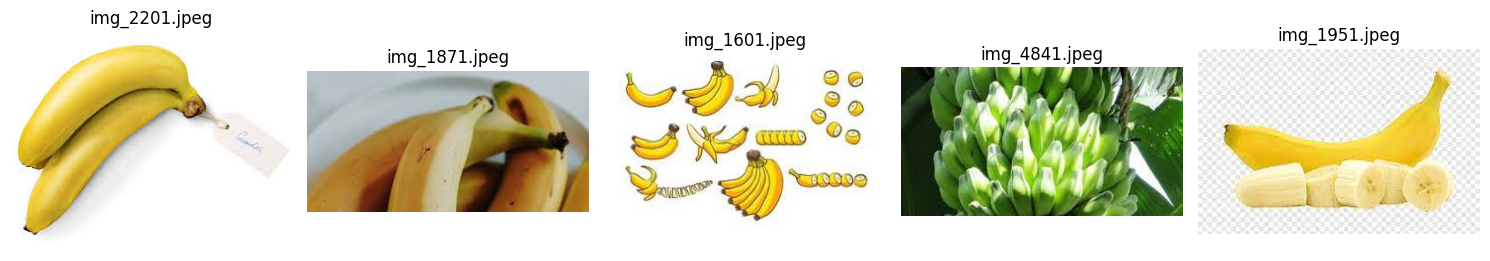

In [75]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fruit_cnn/train/Chuối"

visualize_images(path_to_visualize, num_images=5)

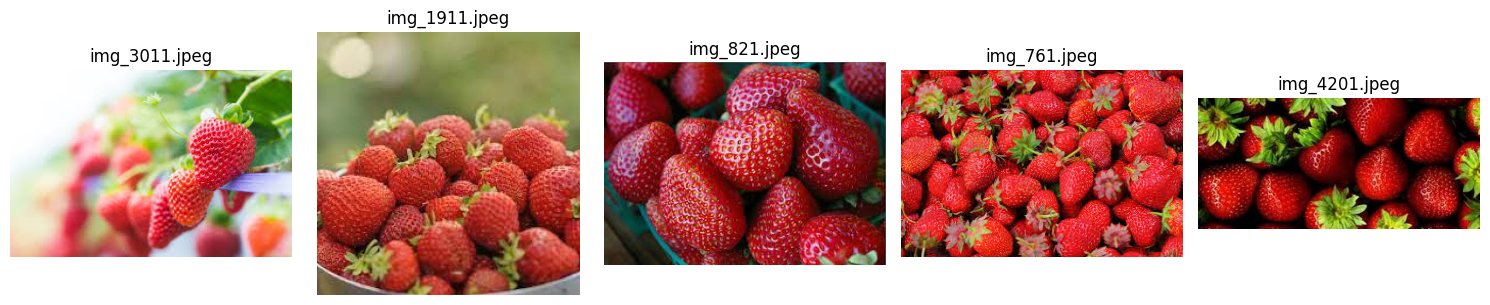

In [76]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fruit_cnn/train/Dâu tây"

visualize_images(path_to_visualize, num_images=5)

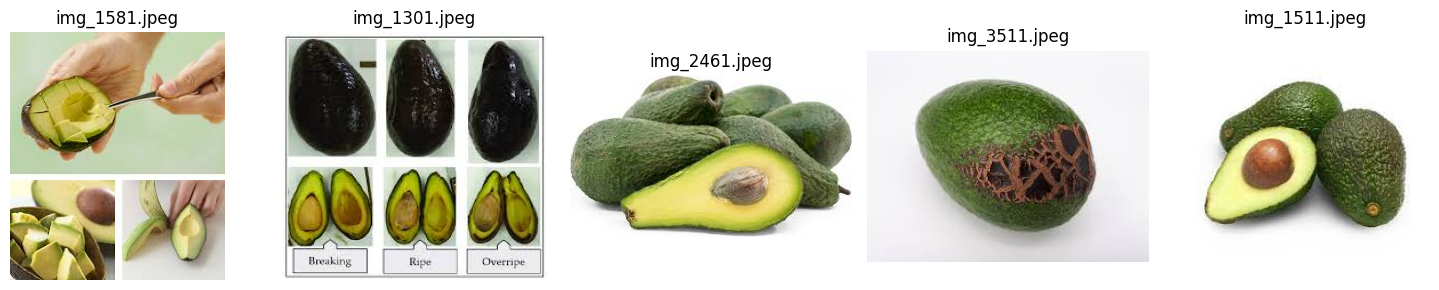

In [77]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fruit_cnn/train/Bơ"

visualize_images(path_to_visualize, num_images=5)

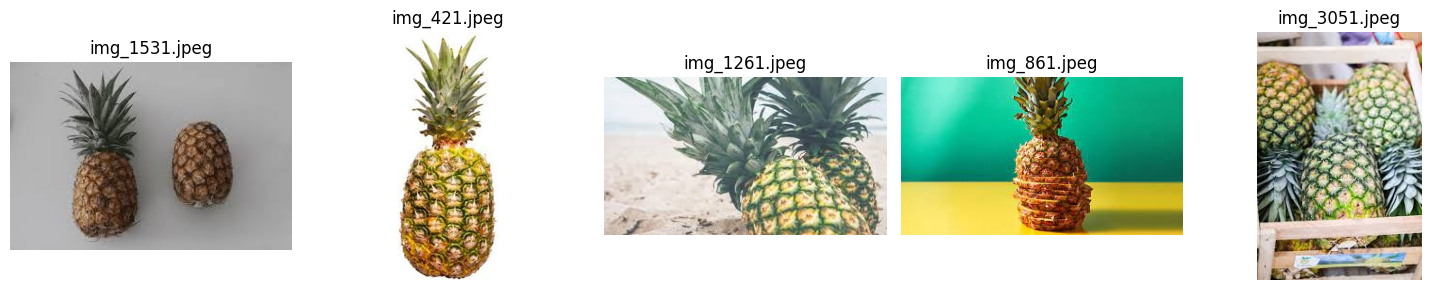

In [78]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fruit_cnn/train/Dứa"

visualize_images(path_to_visualize, num_images=5)

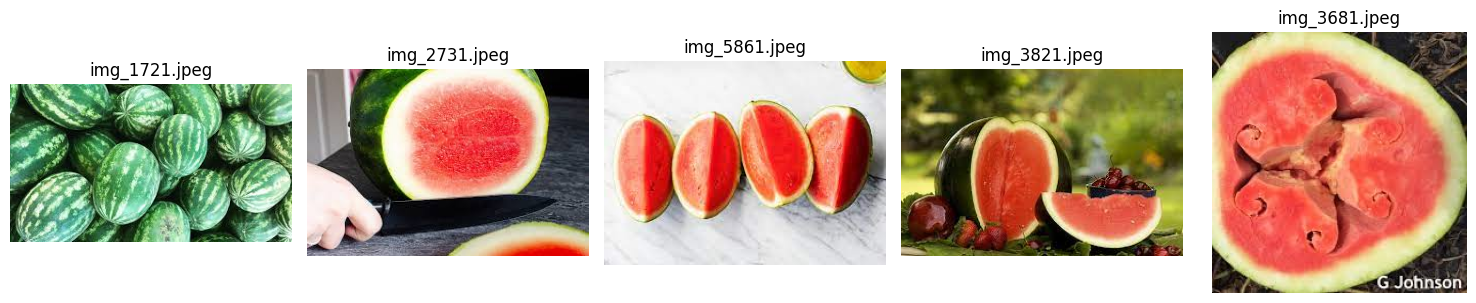

In [79]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fruit_cnn/train/Dưa hấu"

visualize_images(path_to_visualize, num_images=5)

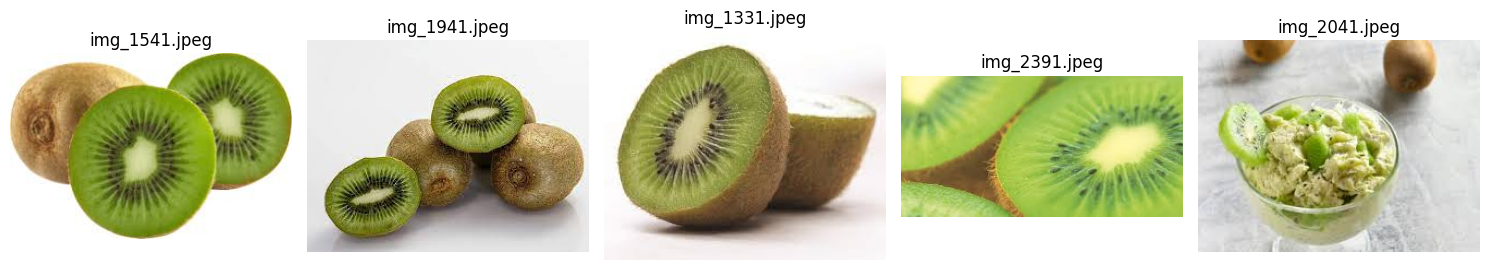

In [80]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fruit_cnn/train/Kiwi"

visualize_images(path_to_visualize, num_images=5)

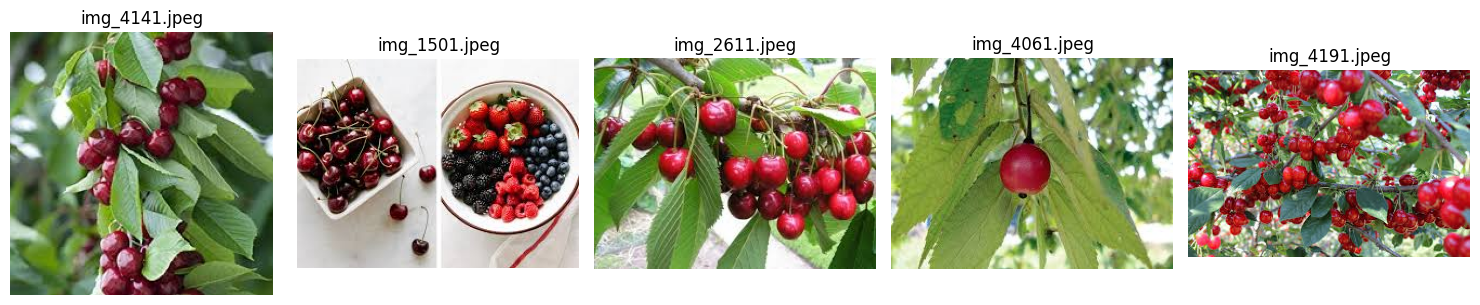

In [81]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fruit_cnn/train/Cherry"

visualize_images(path_to_visualize, num_images=5)

In [82]:
# Load the pre-trained EfficientNetB4 model without the top classification layer
MobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3),
                              pooling='avg')

# Freeze the pre-trained base model layers
MobileNetV2_base.trainable = False

In [83]:
# Build the model
model = Sequential()

# Add the pre-trained Xception base
model.add(MobileNetV2_base)

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.35))

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(220, activation='relu'))

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(60, activation='relu'))

# Add the output layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(10, activation='softmax'))

In [84]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization_3 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 220)               281820    
                                                                 
 dense_10 (Dense)            (None, 60)                13260     
                                                                 
 dense_11 (Dense)            (None, 10)               

In [85]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
 loss='categorical_crossentropy', metrics=['accuracy'])


In [88]:
%%time
# # Define the callback function
early_stopping = EarlyStopping(patience=10)

history= model.fit(train_ds,
    validation_data=validation_ds,
    steps_per_epoch=len(train_ds),
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
58/58 [==============================] - 121s 2s/step - loss: 0.8429 - accuracy: 0.7599 - val_loss: 0.6740 - val_accuracy: 0.8366
Epoch 2/50
58/58 [==============================] - 124s 2s/step - loss: 0.6669 - accuracy: 0.8110 - val_loss: 0.5493 - val_accuracy: 0.8562
Epoch 3/50
58/58 [==============================] - 120s 2s/step - loss: 0.5931 - accuracy: 0.8202 - val_loss: 0.4718 - val_accuracy: 0.8606
Epoch 4/50
58/58 [==============================] - 116s 2s/step - loss: 0.5140 - accuracy: 0.8452 - val_loss: 0.4266 - val_accuracy: 0.8715
Epoch 5/50
58/58 [==============================] - 124s 2s/step - loss: 0.4695 - accuracy: 0.8566 - val_loss: 0.3927 - val_accuracy: 0.8824
Epoch 6/50
58/58 [==============================] - 151s 3s/step - loss: 0.4184 - accuracy: 0.8685 - val_loss: 0.3649 - val_accuracy: 0.8954
Epoch 7/50
58/58 [==============================] - 124s 2s/step - loss: 0.3918 - accuracy: 0.8838 - val_loss: 0.3452 - val_accuracy: 0.8976
Epoch 8/50
58

In [89]:
model.save('/content/drive/MyDrive/fruit_cnn/model.h5')

15/15 [==============================] - 18s 1s/step - loss: 0.2471 - accuracy: 0.9281


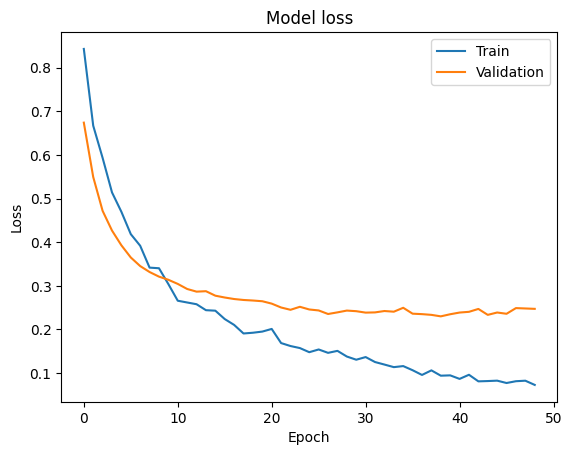

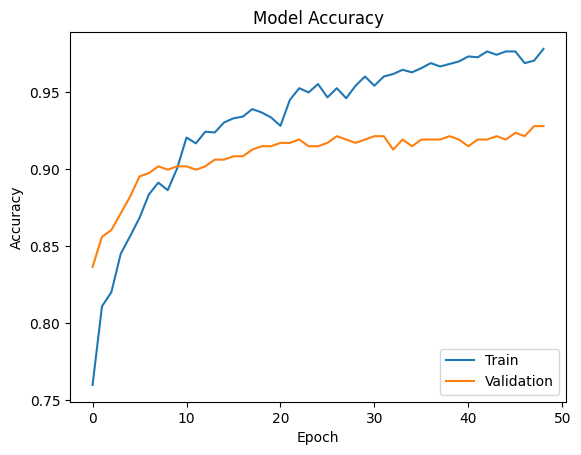

In [90]:
# evaluate the model
loss = model.evaluate(validation_ds)

# Plotting the training and testing loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# plot the accuracy of training and validation

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

1/1 [==============================] - 1s 973ms/step


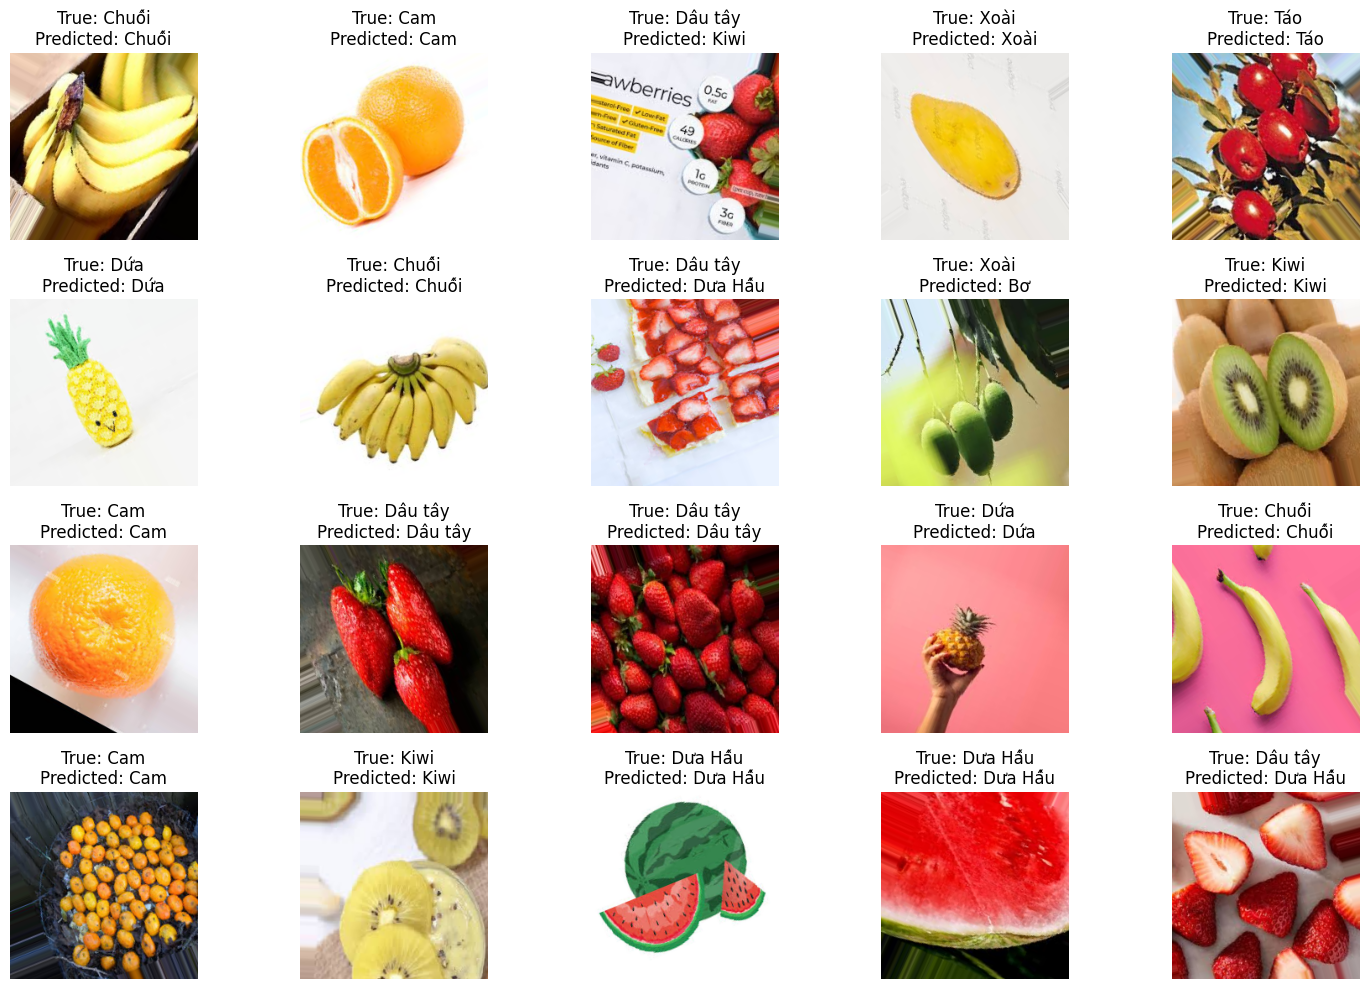

In [91]:
# Get the class labels
class_labels = list(test_ds.class_indices.keys())

# Predict on each image and plot results
num_images = 20
num_images_per_row = 5  # Set the number of images per row
num_rows = 4

plt.figure(figsize=(15, 10))
for i in range(num_images):
    image, label = next(test_ds)
    predictions = model.predict(image)

    # Iterate over each image in the batch
    for j in range(len(image)):
        if i * len(image) + j < num_images:  # Check if the total number of images exceeds the desired count
            predicted_class = class_labels[np.argmax(predictions[j])]
            true_class = class_labels[np.argmax(label[j])]

            plt.subplot(num_rows, num_images_per_row, i * len(image) + j + 1)
            plt.imshow(image[j])
            plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
            plt.axis('off')

plt.tight_layout()
plt.show()